
Lasso model selection: Cross-Validation / AIC / BIC

Use the Akaike information criterion (AIC), the Bayes Information
criterion (BIC) and cross-validation to select an optimal value
of the regularization parameter alpha of the :ref:`lasso` estimator.

Results obtained with LassoLarsIC are based on AIC/BIC criteria.

Information-criterion based model selection is very fast, but it
relies on a proper estimation of degrees of freedom, are
derived for large samples (asymptotic results) and assume the model
is correct, i.e. that the data are actually generated by this model.
They also tend to break when the problem is badly conditioned
(more features than samples).

For cross-validation, we use 20-fold with 2 algorithms to compute the
Lasso path: coordinate descent, as implemented by the LassoCV class, and
Lars (least angle regression) as implemented by the LassoLarsCV class.
Both algorithms give roughly the same results. They differ with regards
to their execution speed and sources of nu

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:85: RuntimeWarning: divide by zero encountered in log10


Computing regularization path using the coordinate descent lasso...
Computing regularization path using the Lars lasso...


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:138: RuntimeWarning: divide by zero encountered in log10


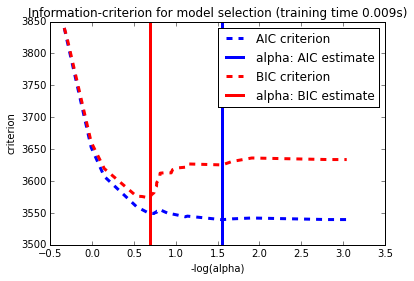

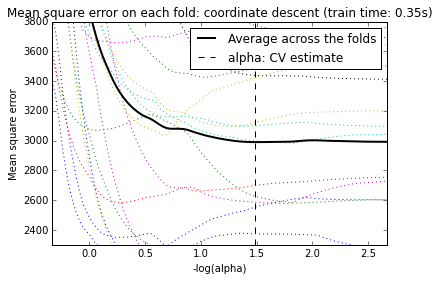

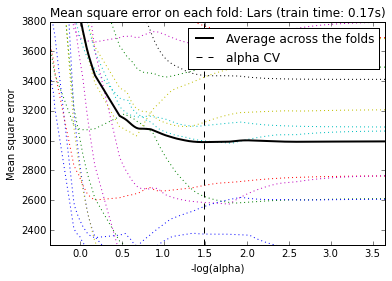

In [1]:
"""
===================================================
Lasso model selection: Cross-Validation / AIC / BIC
===================================================

Use the Akaike information criterion (AIC), the Bayes Information
criterion (BIC) and cross-validation to select an optimal value
of the regularization parameter alpha of the :ref:`lasso` estimator.

Results obtained with LassoLarsIC are based on AIC/BIC criteria.

Information-criterion based model selection is very fast, but it
relies on a proper estimation of degrees of freedom, are
derived for large samples (asymptotic results) and assume the model
is correct, i.e. that the data are actually generated by this model.
They also tend to break when the problem is badly conditioned
(more features than samples).

For cross-validation, we use 20-fold with 2 algorithms to compute the
Lasso path: coordinate descent, as implemented by the LassoCV class, and
Lars (least angle regression) as implemented by the LassoLarsCV class.
Both algorithms give roughly the same results. They differ with regards
to their execution speed and sources of numerical errors.

Lars computes a path solution only for each kink in the path. As a
result, it is very efficient when there are only of few kinks, which is
the case if there are few features or samples. Also, it is able to
compute the full path without setting any meta parameter. On the
opposite, coordinate descent compute the path points on a pre-specified
grid (here we use the default). Thus it is more efficient if the number
of grid points is smaller than the number of kinks in the path. Such a
strategy can be interesting if the number of features is really large
and there are enough samples to select a large amount. In terms of
numerical errors, for heavily correlated variables, Lars will accumulate
more errors, while the coordinate descent algorithm will only sample the
path on a grid.

Note how the optimal value of alpha varies for each fold. This
illustrates why nested-cross validation is necessary when trying to
evaluate the performance of a method for which a parameter is chosen by
cross-validation: this choice of parameter may not be optimal for unseen
data.
"""
print(__doc__)

# Author: Olivier Grisel, Gael Varoquaux, Alexandre Gramfort
# License: BSD 3 clause

import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

rng = np.random.RandomState(42)
X = np.c_[X, rng.randn(X.shape[0], 14)]  # add some bad features

# normalize data as done by Lars to allow for comparison
X /= np.sqrt(np.sum(X ** 2, axis=0))

##############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

##############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

##############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.cv_mse_path_, ':')
plt.plot(m_log_alphas, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()
